In [25]:
import os
import pandas as pd
import random
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.core as ag
from autogluon.core.metrics import make_scorer


import warnings
warnings.filterwarnings("ignore")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) 

In [26]:
train=pd.read_csv("C:/Users/user/Desktop/전기예측량 대회/open/train.csv")
test=pd.read_csv("C:/Users/user/Desktop/전기예측량 대회/open/test.csv")
building=pd.read_csv("C:/Users/user/Desktop/전기예측량 대회/open/building_info.csv")

print(train.head())
print(test.head())
print(building.head())

   num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0     NaN   
1  1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0     NaN   
2  1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0     NaN   
3  1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0     NaN   
4  1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0     NaN   

   일사(MJ/m2)  전력소비량(kWh)  
0        NaN     1085.28  
1        NaN     1047.36  
2        NaN      974.88  
3        NaN      953.76  
4        NaN      986.40  
   num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)
0  1_20220825 00     1  20220825 00   23.5      0.0      2.2     72
1  1_20220825 01     1  20220825 01   23.0      0.0      0.9     72
2  1_20220825 02     1  20220825 02   22.7      0.0      1.5     75
3  1_20220825 03     1  20220825 03   22.1      0.0      1.3     78
4  1_20220825 04     1 

In [27]:
train = train.drop(columns=['num_date_time','일조(hr)','일사(MJ/m2)'],axis=1)
test = test.drop(columns=['num_date_time'])
print(len(building[building['태양광용량(kW)'] == '-']))
print(len(building[building['ESS저장용량(kWh)'] == '-']))
print(len(building[building['PCS용량(kW)'] == '-']))
print(building.info())
#100개중 50%이상 결측치 변수제거
building = building.drop(['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'], axis=1) 

64
95
95
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB
None


In [28]:
train = pd.merge(train, building, on='건물번호', how='left')
test = pd.merge(test, building, on='건물번호', how='left')

In [29]:
train.isna().sum()

건물번호               0
일시                 0
기온(C)              0
강수량(mm)       160069
풍속(m/s)           19
습도(%)              9
전력소비량(kWh)         0
건물유형               0
연면적(m2)            0
냉방면적(m2)           0
dtype: int64

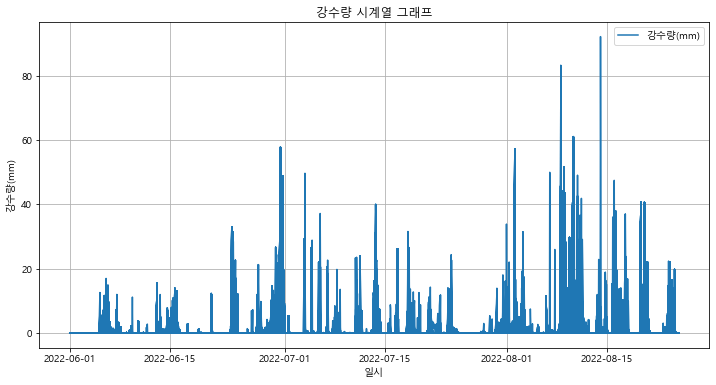

In [30]:
train['강수량(mm)'].fillna(0.0, inplace=True)
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
# '일시' 열을 datetime 형식으로 변환
train['일시'] = pd.to_datetime(train['일시'])

# 강수량에 대한 시계열 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(train['일시'], train['강수량(mm)'], label='강수량(mm)')
plt.xlabel('일시')
plt.ylabel('강수량(mm)')
plt.title('강수량 시계열 그래프')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# '일시' 열을 DataFrame의 인덱스로 설정
train.set_index('일시', inplace=True)

# 결측치 보간을 위해 시계열 보간 수행
train['풍속(m/s)'].interpolate(method='time', inplace=True)
train['습도(%)'].interpolate(method='time', inplace=True)


print(train.isnull().sum())

건물번호          0
기온(C)         0
강수량(mm)       0
풍속(m/s)       0
습도(%)         0
전력소비량(kWh)    0
건물유형          0
연면적(m2)       0
냉방면적(m2)      0
dtype: int64


In [32]:
#파생변수 추가
train['냉방면적 비율'] = train['냉방면적(m2)'] / train['연면적(m2)']
test['냉방면적 비율'] = test['냉방면적(m2)'] / test['연면적(m2)']
#여름철이니 불쾌지수 추가
train['불쾌지수'] = 1.8*train['기온(C)'] - 0.55*(1-(train['습도(%)']/100))*(1.8*train['기온(C)']-26) + 32
test['불쾌지수'] = 1.8*test['기온(C)'] - 0.55*(1-(test['습도(%)']/100))*(1.8*test['기온(C)']-26) + 32

train['체감온도']=13.12+0.6215*train['기온(C)']-13.947*train['풍속(m/s)']**0.16+0.486*train['기온(C)']*train['풍속(m/s)']**0.16
test['체감온도']=13.12+0.6215*test['기온(C)']-13.947*test['풍속(m/s)']**0.16+0.486*test['기온(C)']*test['풍속(m/s)']**0.16

In [33]:
train.isna().sum()

건물번호          0
기온(C)         0
강수량(mm)       0
풍속(m/s)       0
습도(%)         0
전력소비량(kWh)    0
건물유형          0
연면적(m2)       0
냉방면적(m2)      0
냉방면적 비율       0
불쾌지수          0
체감온도          0
dtype: int64

In [34]:
test.isna().sum()

건물번호        0
일시          0
기온(C)       0
강수량(mm)     0
풍속(m/s)     0
습도(%)       0
건물유형        0
연면적(m2)     0
냉방면적(m2)    0
냉방면적 비율     0
불쾌지수        0
체감온도        0
dtype: int64

In [35]:
# '일시' 열을 다시 컬럼으로 변환
train.reset_index('일시', inplace=True)
# 복원된 일시 열을 Datetime 형식으로 변환
train['일시'] = pd.to_datetime(train['일시'])
# '일시' 열을 Datetime 형식으로 변환
test['일시'] = pd.to_datetime(test['일시'])
print(train.head())
print(test.head())


                   일시  건물번호  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  전력소비량(kWh)  건물유형  \
0 2022-06-01 00:00:00     1   18.6      0.0      0.9   42.0     1085.28  건물기타   
1 2022-06-01 01:00:00     1   18.0      0.0      1.1   45.0     1047.36  건물기타   
2 2022-06-01 02:00:00     1   17.7      0.0      1.5   45.0      974.88  건물기타   
3 2022-06-01 03:00:00     1   16.7      0.0      1.4   48.0      953.76  건물기타   
4 2022-06-01 04:00:00     1   18.4      0.0      2.8   43.0      986.40  건물기타   

    연면적(m2)  냉방면적(m2)   냉방면적 비율      불쾌지수       체감온도  
0  110634.0   39570.0  0.357666  63.09388  19.854534  
1  110634.0   39570.0  0.357666  62.46400  19.028110  
2  110634.0   39570.0  0.357666  62.08735  18.417515  
3  110634.0   39570.0  0.357666  60.89884  17.345742  
4  110634.0   39570.0  0.357666  62.88788  18.654749  
   건물번호                  일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  건물유형   연면적(m2)  \
0     1 2022-08-25 00:00:00   23.5      0.0      2.2     72  건물기타  110634.0   
1     1 2022-08-25 01:00:

In [36]:
# 일시 열에서 월, 일, 시간을 추출하여 새로운 컬럼으로 생성
train['month'] = train['일시'].dt.month
train['day'] = train['일시'].dt.day
train['time'] = train['일시'].dt.hour
train['year'] = train['일시'].dt.year



# Test 데이터에 대해 일시를 월, 일, 시간으로 나누기
test['month'] = test['일시'].dt.month
test['day'] = test['일시'].dt.day
test['time'] = test['일시'].dt.hour
test['year'] = test['일시'].dt.year


In [37]:
#주 기준 일 (요일)
train['day_of_week'] = train['일시'].dt.dayofweek
# 년기준 일 
train['day_of_year'] = train['일시'].dt.dayofyear
# 년기준 시간
train['hour_of_year'] = train['일시'].dt.hour + (train['일시'].dt.dayofyear - 1) * 24

#주 기준 일 (요일)
test['day_of_week'] = test['일시'].dt.dayofweek
# 년기준 일 
test['day_of_year'] = test['일시'].dt.dayofyear
# 년기준 시간
test['hour_of_year'] = test['일시'].dt.hour + (test['일시'].dt.dayofyear - 1) * 24

In [ ]:
train=train.drop(columns=['일시','year','건물유형'])
test=test.drop(columns=['일시','year','건물유형'])

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   일시            204000 non-null  datetime64[ns]
 1   건물번호          204000 non-null  int64         
 2   기온(C)         204000 non-null  float64       
 3   강수량(mm)       204000 non-null  float64       
 4   풍속(m/s)       204000 non-null  float64       
 5   습도(%)         204000 non-null  float64       
 6   전력소비량(kWh)    204000 non-null  float64       
 7   건물유형          204000 non-null  object        
 8   연면적(m2)       204000 non-null  float64       
 9   냉방면적(m2)      204000 non-null  float64       
 10  냉방면적 비율       204000 non-null  float64       
 11  불쾌지수          204000 non-null  float64       
 12  체감온도          204000 non-null  float64       
 13  month         204000 non-null  int64         
 14  day           204000 non-null  int64         
 15  time          204

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16800 entries, 0 to 16799
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   건물번호          16800 non-null  int64         
 1   일시            16800 non-null  datetime64[ns]
 2   기온(C)         16800 non-null  float64       
 3   강수량(mm)       16800 non-null  float64       
 4   풍속(m/s)       16800 non-null  float64       
 5   습도(%)         16800 non-null  int64         
 6   건물유형          16800 non-null  object        
 7   연면적(m2)       16800 non-null  float64       
 8   냉방면적(m2)      16800 non-null  float64       
 9   냉방면적 비율       16800 non-null  float64       
 10  불쾌지수          16800 non-null  float64       
 11  체감온도          16800 non-null  float64       
 12  month         16800 non-null  int64         
 13  day           16800 non-null  int64         
 14  time          16800 non-null  int64         
 15  year          16800 non-null  int64 

In [49]:
# SMAPE 손실 함수 정의
def SMAPE(y, pred):
    smape = abs((y - pred))/((abs(y) + abs(pred)) / 2) * 100
    smape = np.mean(smape)
    return smape

In [50]:
# SMAPE를 스코어 함수로
SMAPE_custom_score = make_scorer(name='SMAPE',
                                score_func=SMAPE,
                                optimum=0,
                                greater_is_better=False)

In [ ]:
train_data = TabularDataset(train)
test_data = TabularDataset(test)

label = '전력소비량(kWh)'
eval_metric = SMAPE_custom_score
time_limit = 3600*10

In [53]:
train_data = TabularDataset(train)
test_data = TabularDataset(test)

label = '전력소비량(kWh)'
eval_metric = SMAPE_custom_score


In [55]:
from sklearn.model_selection import train_test_split, KFold

test_data = TabularDataset(test)
kfold = KFold(n_splits=20, shuffle=True)
pres = np.zeros(len(test))
for fold, (train_idx, val_idx) in enumerate(kfold.split(train)):
    print(f'=========={fold+1}fold/20 folds==========')
    train_data = train.copy()
    train_x = train_data.iloc[train_idx]
    val_x = train_data.iloc[val_idx]
    
    train_x =TabularDataset(train_x)
    val_x =TabularDataset(val_x)
    
    predictor = TabularPredictor(
        label=label, eval_metric=eval_metric
    ).fit(train_x,val_x)  
    pre = predictor.predict(test_data)
    pres += (pre/20)
    
sample_submission['label'] = pres
 
sample_submission.to_csv("C:/Users/user/Desktop/전기예측량 대회/open/20fold.csv",index=False)
sample_submission


No path specified. Models will be saved in: "AutogluonModels\ag-20230827_082716\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_082716\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   52.73 GB / 237.11 GB (22.2%)
Train Data Rows:    193800
Train Data Columns: 19
Tuning Data Rows:    10200
Tuning Data Columns: 19
Label Column: 전력소비량(kWh)
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (25488.4, 0.0, 2453.05116, 2444.62488)
	If 'regression' is not the correct problem_type, please manu

==========1fold/20 folds==========


Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1952.36 MB
	Train Data (Original)  Memory Usage: 49.81 MB (2.6% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of 

[1000]	valid_set's l2: 64802.9	valid_set's SMAPE: -9.55391
[2000]	valid_set's l2: 48353	valid_set's SMAPE: -8.24039
[3000]	valid_set's l2: 41453	valid_set's SMAPE: -7.59599
[4000]	valid_set's l2: 37240	valid_set's SMAPE: -7.17038
[5000]	valid_set's l2: 34214.9	valid_set's SMAPE: -6.85378
[6000]	valid_set's l2: 32136.2	valid_set's SMAPE: -6.63645
[7000]	valid_set's l2: 30496.5	valid_set's SMAPE: -6.46924
[8000]	valid_set's l2: 29021.1	valid_set's SMAPE: -6.32414
[9000]	valid_set's l2: 27785.4	valid_set's SMAPE: -6.19176
[10000]	valid_set's l2: 26853	valid_set's SMAPE: -6.08007


	-6.0802	 = Validation score   (-SMAPE)
	82.08s	 = Training   runtime
	4.66s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 38932.3	valid_set's SMAPE: -7.48616
[2000]	valid_set's l2: 26364.4	valid_set's SMAPE: -6.15227
[3000]	valid_set's l2: 21060.4	valid_set's SMAPE: -5.54802
[4000]	valid_set's l2: 18470.7	valid_set's SMAPE: -5.17316
[5000]	valid_set's l2: 16643.6	valid_set's SMAPE: -4.90446
[6000]	valid_set's l2: 15585.8	valid_set's SMAPE: -4.72158
[7000]	valid_set's l2: 14715	valid_set's SMAPE: -4.59159
[8000]	valid_set's l2: 14206.7	valid_set's SMAPE: -4.49788
[9000]	valid_set's l2: 13712.3	valid_set's SMAPE: -4.41038
[10000]	valid_set's l2: 13184.8	valid_set's SMAPE: -4.32571


	-4.3257	 = Validation score   (-SMAPE)
	79.89s	 = Training   runtime
	4.1s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.147	 = Validation score   (-SMAPE)
	84.55s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost ...
	-6.0945	 = Validation score   (-SMAPE)
	1426.19s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.6977	 = Validation score   (-SMAPE)
	13.39s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.3689	 = Validation score   (-SMAPE)
	245.87s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: XGBoost ...
	-4.5095	 = Validation score   (-SMAPE)
	290.03s	 = Training   runtime
	6.23s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-7.9254	 = Validation score   (-SMAPE)
	434.8s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBMLarge ...


[1000]	valid_set's l2: 20147.5	valid_set's SMAPE: -5.51189
[2000]	valid_set's l2: 14767.2	valid_set's SMAPE: -4.61924
[3000]	valid_set's l2: 13160.5	valid_set's SMAPE: -4.28699
[4000]	valid_set's l2: 11997.1	valid_set's SMAPE: -4.04716
[5000]	valid_set's l2: 11303.4	valid_set's SMAPE: -3.89733
[6000]	valid_set's l2: 10932.3	valid_set's SMAPE: -3.80015
[7000]	valid_set's l2: 10673.8	valid_set's SMAPE: -3.73774
[8000]	valid_set's l2: 10442.1	valid_set's SMAPE: -3.67442
[9000]	valid_set's l2: 10238.5	valid_set's SMAPE: -3.61558
[10000]	valid_set's l2: 10056.3	valid_set's SMAPE: -3.56495


	-3.5649	 = Validation score   (-SMAPE)
	115.82s	 = Training   runtime
	7.03s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.3977	 = Validation score   (-SMAPE)
	1.23s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2808.31s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_082716\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_091431\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_091431\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   51.95 GB / 237.

==========2fold/20 folds==========


AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (25488.4, 0.0, 2449.3706, 2436.96655)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1597.75 MB
	Train Data (Original)  Memory Usage: 49.8 MB (3.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting Categor

[1000]	valid_set's l2: 70134.8	valid_set's SMAPE: -9.68954
[2000]	valid_set's l2: 53458.3	valid_set's SMAPE: -8.40828
[3000]	valid_set's l2: 46014.5	valid_set's SMAPE: -7.73971
[4000]	valid_set's l2: 41400.1	valid_set's SMAPE: -7.27776
[5000]	valid_set's l2: 38146.5	valid_set's SMAPE: -6.95528
[6000]	valid_set's l2: 35747.6	valid_set's SMAPE: -6.71838
[7000]	valid_set's l2: 33911.3	valid_set's SMAPE: -6.53601
[8000]	valid_set's l2: 32480.5	valid_set's SMAPE: -6.37565
[9000]	valid_set's l2: 31360.6	valid_set's SMAPE: -6.25047
[10000]	valid_set's l2: 30464.2	valid_set's SMAPE: -6.14715


	-6.147	 = Validation score   (-SMAPE)
	91.22s	 = Training   runtime
	4.7s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 39843.4	valid_set's SMAPE: -7.53566
[2000]	valid_set's l2: 28121.2	valid_set's SMAPE: -6.31689
[3000]	valid_set's l2: 22533.8	valid_set's SMAPE: -5.59912
[4000]	valid_set's l2: 20259.9	valid_set's SMAPE: -5.2206
[5000]	valid_set's l2: 18694	valid_set's SMAPE: -4.99549
[6000]	valid_set's l2: 17576.3	valid_set's SMAPE: -4.81736
[7000]	valid_set's l2: 16788.8	valid_set's SMAPE: -4.68424
[8000]	valid_set's l2: 16056.1	valid_set's SMAPE: -4.57032
[9000]	valid_set's l2: 15608.6	valid_set's SMAPE: -4.48838
[10000]	valid_set's l2: 15274.2	valid_set's SMAPE: -4.41457


	-4.4146	 = Validation score   (-SMAPE)
	85.15s	 = Training   runtime
	4.31s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.2203	 = Validation score   (-SMAPE)
	83.36s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost ...
	-6.2144	 = Validation score   (-SMAPE)
	1459.97s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.7767	 = Validation score   (-SMAPE)
	19.46s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-13.4789	 = Validation score   (-SMAPE)
	265.35s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: XGBoost ...
	-4.6386	 = Validation score   (-SMAPE)
	305.89s	 = Training   runtime
	6.13s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-9.0476	 = Validation score   (-SMAPE)
	333.57s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBMLarge .

[1000]	valid_set's l2: 22239.9	valid_set's SMAPE: -5.61174
[2000]	valid_set's l2: 17349.1	valid_set's SMAPE: -4.82753
[3000]	valid_set's l2: 15163.7	valid_set's SMAPE: -4.43665
[4000]	valid_set's l2: 14052.1	valid_set's SMAPE: -4.19372
[5000]	valid_set's l2: 13277.7	valid_set's SMAPE: -4.02598
[6000]	valid_set's l2: 12799.7	valid_set's SMAPE: -3.91865
[7000]	valid_set's l2: 12445	valid_set's SMAPE: -3.81896
[8000]	valid_set's l2: 12238.6	valid_set's SMAPE: -3.76267
[9000]	valid_set's l2: 12083.3	valid_set's SMAPE: -3.7119
[10000]	valid_set's l2: 11920.6	valid_set's SMAPE: -3.66102


	-3.6612	 = Validation score   (-SMAPE)
	107.02s	 = Training   runtime
	6.14s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.5118	 = Validation score   (-SMAPE)
	0.98s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2786.0s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_091431\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_100120\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_100120\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   51.12 GB / 237.1

==========3fold/20 folds==========


Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1632.37 MB
	Train Data (Original)  Memory Usage: 49.8 MB (3.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of f

[1000]	valid_set's l2: 65868.1	valid_set's SMAPE: -9.33009
[2000]	valid_set's l2: 49975.9	valid_set's SMAPE: -8.18448
[3000]	valid_set's l2: 42539.5	valid_set's SMAPE: -7.55206
[4000]	valid_set's l2: 38190.9	valid_set's SMAPE: -7.18157
[5000]	valid_set's l2: 35384.7	valid_set's SMAPE: -6.90421
[6000]	valid_set's l2: 33190.5	valid_set's SMAPE: -6.66345
[7000]	valid_set's l2: 31412.6	valid_set's SMAPE: -6.4628
[8000]	valid_set's l2: 30018.1	valid_set's SMAPE: -6.30986
[9000]	valid_set's l2: 28958.3	valid_set's SMAPE: -6.18587
[10000]	valid_set's l2: 28001.6	valid_set's SMAPE: -6.07149


	-6.0717	 = Validation score   (-SMAPE)
	90.79s	 = Training   runtime
	4.67s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 35864.8	valid_set's SMAPE: -7.28684
[2000]	valid_set's l2: 24441.9	valid_set's SMAPE: -6.04646
[3000]	valid_set's l2: 19583.4	valid_set's SMAPE: -5.37119
[4000]	valid_set's l2: 17160.1	valid_set's SMAPE: -5.01157
[5000]	valid_set's l2: 15856.6	valid_set's SMAPE: -4.78684
[6000]	valid_set's l2: 14899.1	valid_set's SMAPE: -4.60862
[7000]	valid_set's l2: 14261.6	valid_set's SMAPE: -4.49516
[8000]	valid_set's l2: 13756	valid_set's SMAPE: -4.38954
[9000]	valid_set's l2: 13353.2	valid_set's SMAPE: -4.29796
[10000]	valid_set's l2: 13049.8	valid_set's SMAPE: -4.23432


	-4.2341	 = Validation score   (-SMAPE)
	84.09s	 = Training   runtime
	4.15s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.1505	 = Validation score   (-SMAPE)
	76.98s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-6.1248	 = Validation score   (-SMAPE)
	1453.99s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.7027	 = Validation score   (-SMAPE)
	12.54s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.3612	 = Validation score   (-SMAPE)
	248.5s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: XGBoost ...
	-4.4074	 = Validation score   (-SMAPE)
	293.06s	 = Training   runtime
	6.08s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-9.4022	 = Validation score   (-SMAPE)
	311.27s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBMLarge ..

[1000]	valid_set's l2: 19674.3	valid_set's SMAPE: -5.3759
[2000]	valid_set's l2: 15138.9	valid_set's SMAPE: -4.63996
[3000]	valid_set's l2: 13479.3	valid_set's SMAPE: -4.29717
[4000]	valid_set's l2: 12486.5	valid_set's SMAPE: -4.07533
[5000]	valid_set's l2: 11847.8	valid_set's SMAPE: -3.92566
[6000]	valid_set's l2: 11431.6	valid_set's SMAPE: -3.82509
[7000]	valid_set's l2: 11079.7	valid_set's SMAPE: -3.72699
[8000]	valid_set's l2: 10838.8	valid_set's SMAPE: -3.66304
[9000]	valid_set's l2: 10646.4	valid_set's SMAPE: -3.60938
[10000]	valid_set's l2: 10526.6	valid_set's SMAPE: -3.57399


	-3.5744	 = Validation score   (-SMAPE)
	109.24s	 = Training   runtime
	7.25s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.4158	 = Validation score   (-SMAPE)
	1.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2716.26s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_100120\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_104702\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_104702\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   48.66 GB / 237.1

==========4fold/20 folds==========


Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1317.26 MB
	Train Data (Original)  Memory Usage: 49.8 MB (3.8% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of f

[1000]	valid_set's l2: 66072	valid_set's SMAPE: -9.39451
[2000]	valid_set's l2: 50415.7	valid_set's SMAPE: -8.20423
[3000]	valid_set's l2: 43275.5	valid_set's SMAPE: -7.52165
[4000]	valid_set's l2: 38901.9	valid_set's SMAPE: -7.08243
[5000]	valid_set's l2: 36052.1	valid_set's SMAPE: -6.78349
[6000]	valid_set's l2: 33795.8	valid_set's SMAPE: -6.55445
[7000]	valid_set's l2: 32018.9	valid_set's SMAPE: -6.37163
[8000]	valid_set's l2: 30608.6	valid_set's SMAPE: -6.23552
[9000]	valid_set's l2: 29438.1	valid_set's SMAPE: -6.11429
[10000]	valid_set's l2: 28487.9	valid_set's SMAPE: -6.01089


	-6.0108	 = Validation score   (-SMAPE)
	93.87s	 = Training   runtime
	4.64s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 37024.4	valid_set's SMAPE: -7.23703
[2000]	valid_set's l2: 26247	valid_set's SMAPE: -6.07243
[3000]	valid_set's l2: 21892.9	valid_set's SMAPE: -5.51678
[4000]	valid_set's l2: 19577.2	valid_set's SMAPE: -5.18341
[5000]	valid_set's l2: 18009.3	valid_set's SMAPE: -4.91199
[6000]	valid_set's l2: 17011.4	valid_set's SMAPE: -4.75199
[7000]	valid_set's l2: 16090.5	valid_set's SMAPE: -4.5965
[8000]	valid_set's l2: 15493.1	valid_set's SMAPE: -4.48968
[9000]	valid_set's l2: 15051	valid_set's SMAPE: -4.39901
[10000]	valid_set's l2: 14665	valid_set's SMAPE: -4.31724


	-4.3173	 = Validation score   (-SMAPE)
	83.53s	 = Training   runtime
	4.21s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.2092	 = Validation score   (-SMAPE)
	63.25s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost ...
	-6.0476	 = Validation score   (-SMAPE)
	1458.67s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.6931	 = Validation score   (-SMAPE)
	12.49s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.4084	 = Validation score   (-SMAPE)
	270.75s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: XGBoost ...
	-4.4724	 = Validation score   (-SMAPE)
	309.57s	 = Training   runtime
	7.0s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.087	 = Validation score   (-SMAPE)
	370.82s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBMLarge ...

[1000]	valid_set's l2: 22250.4	valid_set's SMAPE: -5.52763
[2000]	valid_set's l2: 17108.5	valid_set's SMAPE: -4.71189
[3000]	valid_set's l2: 14993	valid_set's SMAPE: -4.29717
[4000]	valid_set's l2: 13987.8	valid_set's SMAPE: -4.07199
[5000]	valid_set's l2: 13383.4	valid_set's SMAPE: -3.92455
[6000]	valid_set's l2: 12991.5	valid_set's SMAPE: -3.81148
[7000]	valid_set's l2: 12690.3	valid_set's SMAPE: -3.73029
[8000]	valid_set's l2: 12467.6	valid_set's SMAPE: -3.66482
[9000]	valid_set's l2: 12316.6	valid_set's SMAPE: -3.61879
[10000]	valid_set's l2: 12183.7	valid_set's SMAPE: -3.58064


	-3.5804	 = Validation score   (-SMAPE)
	104.59s	 = Training   runtime
	6.27s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.4141	 = Validation score   (-SMAPE)
	0.86s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2803.26s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_104702\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_113407\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_113407\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   47.98 GB / 237.

==========5fold/20 folds==========


Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1259.27 MB
	Train Data (Original)  Memory Usage: 49.8 MB (4.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of f

[1000]	valid_set's l2: 59465.9	valid_set's SMAPE: -9.3676
[2000]	valid_set's l2: 43763.2	valid_set's SMAPE: -8.16962
[3000]	valid_set's l2: 37224.9	valid_set's SMAPE: -7.55178
[4000]	valid_set's l2: 33721.3	valid_set's SMAPE: -7.18835
[5000]	valid_set's l2: 31234.4	valid_set's SMAPE: -6.90375
[6000]	valid_set's l2: 29424.1	valid_set's SMAPE: -6.67739
[7000]	valid_set's l2: 27932.3	valid_set's SMAPE: -6.46982
[8000]	valid_set's l2: 26787.6	valid_set's SMAPE: -6.3117
[9000]	valid_set's l2: 25849.3	valid_set's SMAPE: -6.18919
[10000]	valid_set's l2: 25088.9	valid_set's SMAPE: -6.09605


	-6.0963	 = Validation score   (-SMAPE)
	89.83s	 = Training   runtime
	4.88s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 33384.8	valid_set's SMAPE: -7.31252
[2000]	valid_set's l2: 23179.9	valid_set's SMAPE: -6.04492
[3000]	valid_set's l2: 19121.9	valid_set's SMAPE: -5.46147
[4000]	valid_set's l2: 16864.2	valid_set's SMAPE: -5.08877
[5000]	valid_set's l2: 15523.5	valid_set's SMAPE: -4.87519
[6000]	valid_set's l2: 14551.3	valid_set's SMAPE: -4.68241
[7000]	valid_set's l2: 13809	valid_set's SMAPE: -4.53894
[8000]	valid_set's l2: 13214	valid_set's SMAPE: -4.42345
[9000]	valid_set's l2: 12724.7	valid_set's SMAPE: -4.33467
[10000]	valid_set's l2: 12328.3	valid_set's SMAPE: -4.23327


	-4.2331	 = Validation score   (-SMAPE)
	89.63s	 = Training   runtime
	4.1s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.1141	 = Validation score   (-SMAPE)
	61.71s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost ...
	-5.9608	 = Validation score   (-SMAPE)
	1596.32s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.6654	 = Validation score   (-SMAPE)
	14.76s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-11.8225	 = Validation score   (-SMAPE)
	333.66s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: XGBoost ...
	-4.3445	 = Validation score   (-SMAPE)
	342.51s	 = Training   runtime
	8.42s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.8368	 = Validation score   (-SMAPE)
	703.34s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBMLarge ..

[1000]	valid_set's l2: 18742.2	valid_set's SMAPE: -5.32484
[2000]	valid_set's l2: 14344.5	valid_set's SMAPE: -4.57646
[3000]	valid_set's l2: 12552.3	valid_set's SMAPE: -4.22666
[4000]	valid_set's l2: 11596.1	valid_set's SMAPE: -3.98849
[5000]	valid_set's l2: 10991.2	valid_set's SMAPE: -3.83385
[6000]	valid_set's l2: 10622.1	valid_set's SMAPE: -3.73425
[7000]	valid_set's l2: 10332.8	valid_set's SMAPE: -3.65426
[8000]	valid_set's l2: 10087.6	valid_set's SMAPE: -3.58354
[9000]	valid_set's l2: 9873.82	valid_set's SMAPE: -3.52903
[10000]	valid_set's l2: 9731.22	valid_set's SMAPE: -3.48377


	-3.4838	 = Validation score   (-SMAPE)
	211.04s	 = Training   runtime
	8.78s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.3437	 = Validation score   (-SMAPE)
	1.28s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3483.83s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_113407\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_123244\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_123244\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   46.20 GB / 237.

==========6fold/20 folds==========


AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (25488.4, 0.0, 2450.49234, 2437.54945)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1352.72 MB
	Train Data (Original)  Memory Usage: 49.8 MB (3.7% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting Catego

[1000]	valid_set's l2: 62708.3	valid_set's SMAPE: -9.22578
[2000]	valid_set's l2: 46891	valid_set's SMAPE: -7.89482
[3000]	valid_set's l2: 39921.1	valid_set's SMAPE: -7.26815
[4000]	valid_set's l2: 35705.2	valid_set's SMAPE: -6.87735
[5000]	valid_set's l2: 32873.3	valid_set's SMAPE: -6.60325
[6000]	valid_set's l2: 30827.1	valid_set's SMAPE: -6.41107
[7000]	valid_set's l2: 29278.4	valid_set's SMAPE: -6.24968
[8000]	valid_set's l2: 27891.8	valid_set's SMAPE: -6.11517
[9000]	valid_set's l2: 26917.1	valid_set's SMAPE: -6.01566
[10000]	valid_set's l2: 25978.1	valid_set's SMAPE: -5.90556


	-5.9053	 = Validation score   (-SMAPE)
	137.31s	 = Training   runtime
	6.39s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 35090.6	valid_set's SMAPE: -7.34258
[2000]	valid_set's l2: 23553.1	valid_set's SMAPE: -6.03347
[3000]	valid_set's l2: 19722.2	valid_set's SMAPE: -5.49579
[4000]	valid_set's l2: 16989	valid_set's SMAPE: -5.05042
[5000]	valid_set's l2: 15620.8	valid_set's SMAPE: -4.8283
[6000]	valid_set's l2: 14596.2	valid_set's SMAPE: -4.65579
[7000]	valid_set's l2: 13941.8	valid_set's SMAPE: -4.52539
[8000]	valid_set's l2: 13430.7	valid_set's SMAPE: -4.43434
[9000]	valid_set's l2: 12987.4	valid_set's SMAPE: -4.34373
[10000]	valid_set's l2: 12643.5	valid_set's SMAPE: -4.26792


	-4.2678	 = Validation score   (-SMAPE)
	139.27s	 = Training   runtime
	4.93s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.2607	 = Validation score   (-SMAPE)
	56.61s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: CatBoost ...
	-5.9376	 = Validation score   (-SMAPE)
	1593.55s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.7282	 = Validation score   (-SMAPE)
	16.41s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.0941	 = Validation score   (-SMAPE)
	392.02s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: XGBoost ...
	-4.4104	 = Validation score   (-SMAPE)
	339.72s	 = Training   runtime
	7.86s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-7.7882	 = Validation score   (-SMAPE)
	751.97s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: LightGBMLarge 

[1000]	valid_set's l2: 18795.2	valid_set's SMAPE: -5.31908
[2000]	valid_set's l2: 14406.5	valid_set's SMAPE: -4.59127
[3000]	valid_set's l2: 12612.3	valid_set's SMAPE: -4.22682
[4000]	valid_set's l2: 11686.5	valid_set's SMAPE: -4.02047
[5000]	valid_set's l2: 11129.6	valid_set's SMAPE: -3.89538
[6000]	valid_set's l2: 10708.7	valid_set's SMAPE: -3.79871
[7000]	valid_set's l2: 10334.6	valid_set's SMAPE: -3.70909
[8000]	valid_set's l2: 10117.2	valid_set's SMAPE: -3.65652
[9000]	valid_set's l2: 9922.17	valid_set's SMAPE: -3.61164
[10000]	valid_set's l2: 9754.87	valid_set's SMAPE: -3.57209


	-3.572	 = Validation score   (-SMAPE)
	202.24s	 = Training   runtime
	8.03s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.4292	 = Validation score   (-SMAPE)
	1.28s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3672.74s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_123244\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_133426\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_133426\"


==========7fold/20 folds==========


AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   44.16 GB / 237.11 GB (18.6%)
Train Data Rows:    193800
Train Data Columns: 19
Tuning Data Rows:    10200
Tuning Data Columns: 19
Label Column: 전력소비량(kWh)
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (25488.4, 0.0, 2449.99206, 2441.46362)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1342.84 MB
	Train Data (Original)  Memory Usage: 49.8 MB (3.7% of available memory)
	Inferring data type of each f

[1000]	valid_set's l2: 59273.4	valid_set's SMAPE: -9.24257
[2000]	valid_set's l2: 43900.8	valid_set's SMAPE: -8.00596
[3000]	valid_set's l2: 36920.9	valid_set's SMAPE: -7.30819
[4000]	valid_set's l2: 32879.1	valid_set's SMAPE: -6.877
[5000]	valid_set's l2: 30019	valid_set's SMAPE: -6.5756
[6000]	valid_set's l2: 27991.7	valid_set's SMAPE: -6.3674
[7000]	valid_set's l2: 26520.8	valid_set's SMAPE: -6.19952
[8000]	valid_set's l2: 25387.4	valid_set's SMAPE: -6.0766
[9000]	valid_set's l2: 24463.8	valid_set's SMAPE: -5.96539
[10000]	valid_set's l2: 23619	valid_set's SMAPE: -5.85555


	-5.8555	 = Validation score   (-SMAPE)
	145.77s	 = Training   runtime
	5.7s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 33086.2	valid_set's SMAPE: -7.18565
[2000]	valid_set's l2: 22518.1	valid_set's SMAPE: -5.97762
[3000]	valid_set's l2: 18343.4	valid_set's SMAPE: -5.37216
[4000]	valid_set's l2: 16155.6	valid_set's SMAPE: -5.00569
[5000]	valid_set's l2: 14767.6	valid_set's SMAPE: -4.7618
[6000]	valid_set's l2: 13832.8	valid_set's SMAPE: -4.5764
[7000]	valid_set's l2: 13021.1	valid_set's SMAPE: -4.4181
[8000]	valid_set's l2: 12460.4	valid_set's SMAPE: -4.29993
[9000]	valid_set's l2: 12126.9	valid_set's SMAPE: -4.22432
[10000]	valid_set's l2: 11789.9	valid_set's SMAPE: -4.1473


	-4.1474	 = Validation score   (-SMAPE)
	205.07s	 = Training   runtime
	6.18s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.1232	 = Validation score   (-SMAPE)
	83.29s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-5.9188	 = Validation score   (-SMAPE)
	1513.71s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.6257	 = Validation score   (-SMAPE)
	15.86s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.8765	 = Validation score   (-SMAPE)
	333.56s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: XGBoost ...
	-4.4185	 = Validation score   (-SMAPE)
	332.61s	 = Training   runtime
	8.0s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-7.7484	 = Validation score   (-SMAPE)
	656.05s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBMLarge .

[1000]	valid_set's l2: 18473.5	valid_set's SMAPE: -5.28126
[2000]	valid_set's l2: 14030.3	valid_set's SMAPE: -4.55277
[3000]	valid_set's l2: 12216.9	valid_set's SMAPE: -4.1848
[4000]	valid_set's l2: 11280.2	valid_set's SMAPE: -3.95149
[5000]	valid_set's l2: 10779.7	valid_set's SMAPE: -3.82002
[6000]	valid_set's l2: 10360.1	valid_set's SMAPE: -3.70062
[7000]	valid_set's l2: 10083.9	valid_set's SMAPE: -3.61971
[8000]	valid_set's l2: 9885.93	valid_set's SMAPE: -3.56451
[9000]	valid_set's l2: 9736.23	valid_set's SMAPE: -3.51922
[10000]	valid_set's l2: 9615.28	valid_set's SMAPE: -3.48289


	-3.4831	 = Validation score   (-SMAPE)
	164.65s	 = Training   runtime
	8.5s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.3397	 = Validation score   (-SMAPE)
	1.18s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3494.86s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_133426\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_143312\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_143312\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   42.32 GB / 237.1

==========8fold/20 folds==========


Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1484.84 MB
	Train Data (Original)  Memory Usage: 49.8 MB (3.4% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of f

[1000]	valid_set's l2: 68982	valid_set's SMAPE: -9.63486
[2000]	valid_set's l2: 52124.1	valid_set's SMAPE: -8.30254
[3000]	valid_set's l2: 44479.5	valid_set's SMAPE: -7.59888
[4000]	valid_set's l2: 39904.3	valid_set's SMAPE: -7.14934
[5000]	valid_set's l2: 36687.7	valid_set's SMAPE: -6.84148
[6000]	valid_set's l2: 34562.1	valid_set's SMAPE: -6.62564
[7000]	valid_set's l2: 32554.5	valid_set's SMAPE: -6.43471
[8000]	valid_set's l2: 31065.7	valid_set's SMAPE: -6.28381
[9000]	valid_set's l2: 29886.3	valid_set's SMAPE: -6.14794
[10000]	valid_set's l2: 28919.5	valid_set's SMAPE: -6.04922


	-6.0491	 = Validation score   (-SMAPE)
	130.41s	 = Training   runtime
	5.55s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 38073.6	valid_set's SMAPE: -7.4037
[2000]	valid_set's l2: 25793	valid_set's SMAPE: -6.11768
[3000]	valid_set's l2: 21215.1	valid_set's SMAPE: -5.60355
[4000]	valid_set's l2: 18353.7	valid_set's SMAPE: -5.16186
[5000]	valid_set's l2: 16887.4	valid_set's SMAPE: -4.91992
[6000]	valid_set's l2: 15844.1	valid_set's SMAPE: -4.73579
[7000]	valid_set's l2: 15162.9	valid_set's SMAPE: -4.59218
[8000]	valid_set's l2: 14534.2	valid_set's SMAPE: -4.48235
[9000]	valid_set's l2: 14037.8	valid_set's SMAPE: -4.39951
[10000]	valid_set's l2: 13660.1	valid_set's SMAPE: -4.34164


	-4.3414	 = Validation score   (-SMAPE)
	98.53s	 = Training   runtime
	4.86s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.1168	 = Validation score   (-SMAPE)
	69.41s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost ...
	-6.1378	 = Validation score   (-SMAPE)
	1413.22s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.7282	 = Validation score   (-SMAPE)
	14.32s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-13.8541	 = Validation score   (-SMAPE)
	429.12s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: XGBoost ...
Available Memory: 500 MB
Estimated XGB model size: 0 MB
	-5.631	 = Validation score   (-SMAPE)
	94.12s	 = Training   runtime
	1.81s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-7.7257	 = Validation score   (-SMAPE)
	1292.38s	 = Training   runtime
	0.38s

[1000]	valid_set's l2: 21084.9	valid_set's SMAPE: -5.46322
[2000]	valid_set's l2: 15954.1	valid_set's SMAPE: -4.66367
[3000]	valid_set's l2: 14193.1	valid_set's SMAPE: -4.30489
[4000]	valid_set's l2: 13259.8	valid_set's SMAPE: -4.11304
[5000]	valid_set's l2: 12691.9	valid_set's SMAPE: -3.96449
[6000]	valid_set's l2: 12277.3	valid_set's SMAPE: -3.85579
[7000]	valid_set's l2: 11901.3	valid_set's SMAPE: -3.75516
[8000]	valid_set's l2: 11687.7	valid_set's SMAPE: -3.70029
[9000]	valid_set's l2: 11494.7	valid_set's SMAPE: -3.64805
[10000]	valid_set's l2: 11351.6	valid_set's SMAPE: -3.61167


	-3.6116	 = Validation score   (-SMAPE)
	251.23s	 = Training   runtime
	9.91s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.4338	 = Validation score   (-SMAPE)
	1.56s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3832.01s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_143312\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_153726\"


==========9fold/20 folds==========


	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_153726\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   38.64 GB / 237.11 GB (16.3%)
Train Data Rows:    193800
Train Data Columns: 19
Tuning Data Rows:    10200
Tuning Data Columns: 19
Label Column: 전력소비량(kWh)
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (25488.4, 0.0, 2453.01522, 2445.01769)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify pro

[1000]	valid_set's l2: 65208.1	valid_set's SMAPE: -9.51648
[2000]	valid_set's l2: 49325.6	valid_set's SMAPE: -8.32423
[3000]	valid_set's l2: 42267.9	valid_set's SMAPE: -7.67181
[4000]	valid_set's l2: 38083.5	valid_set's SMAPE: -7.23504
[5000]	valid_set's l2: 35067.5	valid_set's SMAPE: -6.92099
[6000]	valid_set's l2: 32934	valid_set's SMAPE: -6.70127
[7000]	valid_set's l2: 31128.4	valid_set's SMAPE: -6.50706
[8000]	valid_set's l2: 29744.8	valid_set's SMAPE: -6.35758
[9000]	valid_set's l2: 28533.9	valid_set's SMAPE: -6.22268
[10000]	valid_set's l2: 27483.4	valid_set's SMAPE: -6.09903


	-6.0989	 = Validation score   (-SMAPE)
	131.97s	 = Training   runtime
	5.56s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 33777.6	valid_set's SMAPE: -7.32372
[2000]	valid_set's l2: 23232.7	valid_set's SMAPE: -6.12344
[3000]	valid_set's l2: 19013.6	valid_set's SMAPE: -5.53098
[4000]	valid_set's l2: 16651.6	valid_set's SMAPE: -5.14582
[5000]	valid_set's l2: 15251.9	valid_set's SMAPE: -4.89117
[6000]	valid_set's l2: 14435.3	valid_set's SMAPE: -4.73446
[7000]	valid_set's l2: 13826.3	valid_set's SMAPE: -4.5865
[8000]	valid_set's l2: 13351.4	valid_set's SMAPE: -4.49079
[9000]	valid_set's l2: 12940.3	valid_set's SMAPE: -4.40802
[10000]	valid_set's l2: 12576.7	valid_set's SMAPE: -4.34277


	-4.3425	 = Validation score   (-SMAPE)
	97.05s	 = Training   runtime
	4.65s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.112	 = Validation score   (-SMAPE)
	96.08s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost ...
	-6.0386	 = Validation score   (-SMAPE)
	1399.07s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.6963	 = Validation score   (-SMAPE)
	21.58s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.8553	 = Validation score   (-SMAPE)
	292.73s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: XGBoost ...
	-4.4229	 = Validation score   (-SMAPE)
	340.06s	 = Training   runtime
	7.45s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.1004	 = Validation score   (-SMAPE)
	400.56s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBMLarge ..

[1000]	valid_set's l2: 19432.2	valid_set's SMAPE: -5.46567
[2000]	valid_set's l2: 14546.3	valid_set's SMAPE: -4.65611
[3000]	valid_set's l2: 12800.8	valid_set's SMAPE: -4.2793
[4000]	valid_set's l2: 11925.9	valid_set's SMAPE: -4.07699
[5000]	valid_set's l2: 11327.7	valid_set's SMAPE: -3.93428
[6000]	valid_set's l2: 10822.6	valid_set's SMAPE: -3.81437
[7000]	valid_set's l2: 10444	valid_set's SMAPE: -3.70745
[8000]	valid_set's l2: 10263.2	valid_set's SMAPE: -3.65854
[9000]	valid_set's l2: 10135.6	valid_set's SMAPE: -3.61761
[10000]	valid_set's l2: 10029	valid_set's SMAPE: -3.57857


	-3.5791	 = Validation score   (-SMAPE)
	115.35s	 = Training   runtime
	6.77s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.4072	 = Validation score   (-SMAPE)
	0.96s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2934.72s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_153726\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_162647\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_162647\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   46.07 GB / 237.

==========10fold/20 folds==========


Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2160.06 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.3% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of f

[1000]	valid_set's l2: 63293.5	valid_set's SMAPE: -9.34272
[2000]	valid_set's l2: 47815.8	valid_set's SMAPE: -8.10249
[3000]	valid_set's l2: 40697.6	valid_set's SMAPE: -7.42838
[4000]	valid_set's l2: 36670.4	valid_set's SMAPE: -6.99775
[5000]	valid_set's l2: 33772.1	valid_set's SMAPE: -6.665
[6000]	valid_set's l2: 31669.3	valid_set's SMAPE: -6.42177
[7000]	valid_set's l2: 30096	valid_set's SMAPE: -6.22141
[8000]	valid_set's l2: 28774.5	valid_set's SMAPE: -6.06654
[9000]	valid_set's l2: 27666.5	valid_set's SMAPE: -5.92865
[10000]	valid_set's l2: 26741.8	valid_set's SMAPE: -5.81731


	-5.817	 = Validation score   (-SMAPE)
	97.56s	 = Training   runtime
	5.35s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 36984.4	valid_set's SMAPE: -7.41413
[2000]	valid_set's l2: 25345.4	valid_set's SMAPE: -6.08624
[3000]	valid_set's l2: 21113	valid_set's SMAPE: -5.50361
[4000]	valid_set's l2: 18477.7	valid_set's SMAPE: -5.14061
[5000]	valid_set's l2: 17046	valid_set's SMAPE: -4.89997
[6000]	valid_set's l2: 15993.3	valid_set's SMAPE: -4.72765
[7000]	valid_set's l2: 15229.4	valid_set's SMAPE: -4.58477
[8000]	valid_set's l2: 14603.8	valid_set's SMAPE: -4.46544
[9000]	valid_set's l2: 14092.3	valid_set's SMAPE: -4.36643
[10000]	valid_set's l2: 13705.4	valid_set's SMAPE: -4.2786


	-4.2787	 = Validation score   (-SMAPE)
	89.3s	 = Training   runtime
	4.61s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.2007	 = Validation score   (-SMAPE)
	87.44s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-5.9887	 = Validation score   (-SMAPE)
	1383.57s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.7033	 = Validation score   (-SMAPE)
	20.01s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-11.6931	 = Validation score   (-SMAPE)
	291.56s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: XGBoost ...
	-4.3772	 = Validation score   (-SMAPE)
	336.14s	 = Training   runtime
	7.5s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.0802	 = Validation score   (-SMAPE)
	432.36s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBMLarge ...

[1000]	valid_set's l2: 20440.5	valid_set's SMAPE: -5.38281
[2000]	valid_set's l2: 15152.7	valid_set's SMAPE: -4.60256
[3000]	valid_set's l2: 13316.5	valid_set's SMAPE: -4.22676
[4000]	valid_set's l2: 12244.5	valid_set's SMAPE: -4.00485
[5000]	valid_set's l2: 11613.5	valid_set's SMAPE: -3.85337
[6000]	valid_set's l2: 11194.6	valid_set's SMAPE: -3.75897
[7000]	valid_set's l2: 10826.3	valid_set's SMAPE: -3.66358
[8000]	valid_set's l2: 10586.8	valid_set's SMAPE: -3.59511
[9000]	valid_set's l2: 10411.4	valid_set's SMAPE: -3.54208
[10000]	valid_set's l2: 10298.2	valid_set's SMAPE: -3.50745


	-3.5076	 = Validation score   (-SMAPE)
	121.15s	 = Training   runtime
	7.29s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.3844	 = Validation score   (-SMAPE)
	1.09s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2899.02s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_162647\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_171535\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_171535\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   44.27 GB / 237.

==========11fold/20 folds==========


Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1997.52 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.5% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of f

[1000]	valid_set's l2: 65031.6	valid_set's SMAPE: -9.50337
[2000]	valid_set's l2: 48824.6	valid_set's SMAPE: -8.19641
[3000]	valid_set's l2: 42124.6	valid_set's SMAPE: -7.49485
[4000]	valid_set's l2: 38157.4	valid_set's SMAPE: -7.07629
[5000]	valid_set's l2: 35308.6	valid_set's SMAPE: -6.76667
[6000]	valid_set's l2: 33276.3	valid_set's SMAPE: -6.5001
[7000]	valid_set's l2: 31663.2	valid_set's SMAPE: -6.30158
[8000]	valid_set's l2: 30438.5	valid_set's SMAPE: -6.16238
[9000]	valid_set's l2: 29585.9	valid_set's SMAPE: -6.05569
[10000]	valid_set's l2: 28773.3	valid_set's SMAPE: -5.95483


	-5.955	 = Validation score   (-SMAPE)
	105.84s	 = Training   runtime
	5.64s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 36375.1	valid_set's SMAPE: -7.46547
[2000]	valid_set's l2: 25419.9	valid_set's SMAPE: -6.23544
[3000]	valid_set's l2: 20997.2	valid_set's SMAPE: -5.64541
[4000]	valid_set's l2: 18483.6	valid_set's SMAPE: -5.23035
[5000]	valid_set's l2: 16688.2	valid_set's SMAPE: -4.93847
[6000]	valid_set's l2: 15612.8	valid_set's SMAPE: -4.74557
[7000]	valid_set's l2: 14953	valid_set's SMAPE: -4.60145
[8000]	valid_set's l2: 14410.6	valid_set's SMAPE: -4.48238
[9000]	valid_set's l2: 14017.6	valid_set's SMAPE: -4.38638
[10000]	valid_set's l2: 13674.4	valid_set's SMAPE: -4.32054


	-4.3206	 = Validation score   (-SMAPE)
	97.75s	 = Training   runtime
	4.96s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.2596	 = Validation score   (-SMAPE)
	80.82s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-6.0335	 = Validation score   (-SMAPE)
	1363.75s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.7461	 = Validation score   (-SMAPE)
	21.27s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-13.5678	 = Validation score   (-SMAPE)
	281.63s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: XGBoost ...
	-4.5123	 = Validation score   (-SMAPE)
	311.63s	 = Training   runtime
	7.88s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-7.8478	 = Validation score   (-SMAPE)
	682.98s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBMLarge .

[1000]	valid_set's l2: 21088.9	valid_set's SMAPE: -5.51329
[2000]	valid_set's l2: 16270.7	valid_set's SMAPE: -4.67126
[3000]	valid_set's l2: 14455.3	valid_set's SMAPE: -4.29132
[4000]	valid_set's l2: 13448.7	valid_set's SMAPE: -4.0862
[5000]	valid_set's l2: 12884.5	valid_set's SMAPE: -3.93747
[6000]	valid_set's l2: 12476.4	valid_set's SMAPE: -3.83413
[7000]	valid_set's l2: 12144.5	valid_set's SMAPE: -3.7458
[8000]	valid_set's l2: 11964.7	valid_set's SMAPE: -3.68997
[9000]	valid_set's l2: 11824	valid_set's SMAPE: -3.64085
[10000]	valid_set's l2: 11700.6	valid_set's SMAPE: -3.59565


	-3.5958	 = Validation score   (-SMAPE)
	117.5s	 = Training   runtime
	7.45s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.4482	 = Validation score   (-SMAPE)
	1.03s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3103.94s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_171535\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_180746\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_180746\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   41.84 GB / 237.1

==========12fold/20 folds==========


Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2365.15 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do n

[1000]	valid_set's l2: 67140.9	valid_set's SMAPE: -9.46627
[2000]	valid_set's l2: 50483.6	valid_set's SMAPE: -8.24025
[3000]	valid_set's l2: 42839	valid_set's SMAPE: -7.51791
[4000]	valid_set's l2: 38550.5	valid_set's SMAPE: -7.10185
[5000]	valid_set's l2: 35794.4	valid_set's SMAPE: -6.81252
[6000]	valid_set's l2: 33702.7	valid_set's SMAPE: -6.5975
[7000]	valid_set's l2: 32123.1	valid_set's SMAPE: -6.43013
[8000]	valid_set's l2: 30768.3	valid_set's SMAPE: -6.2934
[9000]	valid_set's l2: 29660	valid_set's SMAPE: -6.17106
[10000]	valid_set's l2: 28611.7	valid_set's SMAPE: -6.07176


	-6.0715	 = Validation score   (-SMAPE)
	110.52s	 = Training   runtime
	5.03s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 36897	valid_set's SMAPE: -7.29712
[2000]	valid_set's l2: 24535.1	valid_set's SMAPE: -6.01226
[3000]	valid_set's l2: 20196.7	valid_set's SMAPE: -5.38619
[4000]	valid_set's l2: 17928.3	valid_set's SMAPE: -5.02438
[5000]	valid_set's l2: 16575.5	valid_set's SMAPE: -4.83032
[6000]	valid_set's l2: 15556.4	valid_set's SMAPE: -4.66782
[7000]	valid_set's l2: 14800.2	valid_set's SMAPE: -4.54012
[8000]	valid_set's l2: 13838	valid_set's SMAPE: -4.37808
[9000]	valid_set's l2: 13365	valid_set's SMAPE: -4.28839
[10000]	valid_set's l2: 12914.8	valid_set's SMAPE: -4.20132


	-4.2014	 = Validation score   (-SMAPE)
	86.67s	 = Training   runtime
	4.46s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.1211	 = Validation score   (-SMAPE)
	99.46s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost ...
	-5.939	 = Validation score   (-SMAPE)
	1274.71s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.6359	 = Validation score   (-SMAPE)
	20.24s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.4596	 = Validation score   (-SMAPE)
	398.33s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: XGBoost ...
	-4.4023	 = Validation score   (-SMAPE)
	333.53s	 = Training   runtime
	7.19s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.9202	 = Validation score   (-SMAPE)
	557.71s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: LightGBMLarge ...

[1000]	valid_set's l2: 19391.3	valid_set's SMAPE: -5.36728
[2000]	valid_set's l2: 14588.9	valid_set's SMAPE: -4.57164
[3000]	valid_set's l2: 12819.4	valid_set's SMAPE: -4.22666
[4000]	valid_set's l2: 11824	valid_set's SMAPE: -4.02939
[5000]	valid_set's l2: 11196.1	valid_set's SMAPE: -3.89088
[6000]	valid_set's l2: 10649.7	valid_set's SMAPE: -3.76016
[7000]	valid_set's l2: 10335.5	valid_set's SMAPE: -3.68556
[8000]	valid_set's l2: 10088.5	valid_set's SMAPE: -3.61816
[9000]	valid_set's l2: 9915.9	valid_set's SMAPE: -3.56695
[10000]	valid_set's l2: 9737.15	valid_set's SMAPE: -3.52006


	-3.5196	 = Validation score   (-SMAPE)
	119.04s	 = Training   runtime
	6.73s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.3668	 = Validation score   (-SMAPE)
	0.92s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3038.29s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_180746\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_185851\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_185851\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   39.43 GB / 237.

==========13fold/20 folds==========


Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2386.5 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of fe

[1000]	valid_set's l2: 72379.6	valid_set's SMAPE: -9.66176
[2000]	valid_set's l2: 54691	valid_set's SMAPE: -8.26267
[3000]	valid_set's l2: 46775.7	valid_set's SMAPE: -7.62186
[4000]	valid_set's l2: 42279	valid_set's SMAPE: -7.18589
[5000]	valid_set's l2: 39181.1	valid_set's SMAPE: -6.88689
[6000]	valid_set's l2: 36669.9	valid_set's SMAPE: -6.61257
[7000]	valid_set's l2: 34822.6	valid_set's SMAPE: -6.4304
[8000]	valid_set's l2: 33243.3	valid_set's SMAPE: -6.2549
[9000]	valid_set's l2: 31855.1	valid_set's SMAPE: -6.11926
[10000]	valid_set's l2: 30794.9	valid_set's SMAPE: -6.01791


	-6.0177	 = Validation score   (-SMAPE)
	97.08s	 = Training   runtime
	5.27s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 39711	valid_set's SMAPE: -7.56221
[2000]	valid_set's l2: 25941.6	valid_set's SMAPE: -6.17401
[3000]	valid_set's l2: 21412.2	valid_set's SMAPE: -5.58275
[4000]	valid_set's l2: 18819.1	valid_set's SMAPE: -5.19385
[5000]	valid_set's l2: 17227.3	valid_set's SMAPE: -4.92287
[6000]	valid_set's l2: 16288.2	valid_set's SMAPE: -4.76747
[7000]	valid_set's l2: 15563.7	valid_set's SMAPE: -4.63497
[8000]	valid_set's l2: 14975	valid_set's SMAPE: -4.52284
[9000]	valid_set's l2: 14416.1	valid_set's SMAPE: -4.4124
[10000]	valid_set's l2: 13941.6	valid_set's SMAPE: -4.33325


	-4.3327	 = Validation score   (-SMAPE)
	89.45s	 = Training   runtime
	4.58s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.2334	 = Validation score   (-SMAPE)
	94.68s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost ...
	-6.192	 = Validation score   (-SMAPE)
	1386.93s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.8268	 = Validation score   (-SMAPE)
	20.74s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-13.0945	 = Validation score   (-SMAPE)
	305.48s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: XGBoost ...
	-4.5611	 = Validation score   (-SMAPE)
	313.89s	 = Training   runtime
	7.46s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-10.3461	 = Validation score   (-SMAPE)
	323.24s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBMLarge .

[1000]	valid_set's l2: 21322	valid_set's SMAPE: -5.54871
[2000]	valid_set's l2: 16393.7	valid_set's SMAPE: -4.79856
[3000]	valid_set's l2: 14084.3	valid_set's SMAPE: -4.40594
[4000]	valid_set's l2: 12845	valid_set's SMAPE: -4.15651
[5000]	valid_set's l2: 12288.6	valid_set's SMAPE: -4.00642
[6000]	valid_set's l2: 11912.4	valid_set's SMAPE: -3.90863
[7000]	valid_set's l2: 11594.3	valid_set's SMAPE: -3.83524
[8000]	valid_set's l2: 11371.9	valid_set's SMAPE: -3.77228
[9000]	valid_set's l2: 11165.8	valid_set's SMAPE: -3.71561
[10000]	valid_set's l2: 11010.1	valid_set's SMAPE: -3.66924


	-3.6691	 = Validation score   (-SMAPE)
	114.85s	 = Training   runtime
	6.8s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.5079	 = Validation score   (-SMAPE)
	0.91s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2784.82s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_185851\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_194551\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_194551\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   37.41 GB / 237.1

==========14fold/20 folds==========


	Available Memory:                    2397.69 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, speci

[1000]	valid_set's l2: 60739.8	valid_set's SMAPE: -9.38358
[2000]	valid_set's l2: 45973.8	valid_set's SMAPE: -8.16622
[3000]	valid_set's l2: 39707.1	valid_set's SMAPE: -7.56141
[4000]	valid_set's l2: 35605.1	valid_set's SMAPE: -7.13259
[5000]	valid_set's l2: 32728.8	valid_set's SMAPE: -6.81065
[6000]	valid_set's l2: 30616.6	valid_set's SMAPE: -6.57257
[7000]	valid_set's l2: 28909.4	valid_set's SMAPE: -6.37809
[8000]	valid_set's l2: 27562.9	valid_set's SMAPE: -6.22039
[9000]	valid_set's l2: 26474.6	valid_set's SMAPE: -6.09539
[10000]	valid_set's l2: 25521.4	valid_set's SMAPE: -5.97206


	-5.9721	 = Validation score   (-SMAPE)
	99.21s	 = Training   runtime
	5.79s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 36247.4	valid_set's SMAPE: -7.37198
[2000]	valid_set's l2: 23904.9	valid_set's SMAPE: -6.02984
[3000]	valid_set's l2: 19641.1	valid_set's SMAPE: -5.4547
[4000]	valid_set's l2: 17259.4	valid_set's SMAPE: -5.09834
[5000]	valid_set's l2: 15824	valid_set's SMAPE: -4.84358
[6000]	valid_set's l2: 14927.2	valid_set's SMAPE: -4.68278
[7000]	valid_set's l2: 14194.5	valid_set's SMAPE: -4.54771
[8000]	valid_set's l2: 13646.7	valid_set's SMAPE: -4.43396
[9000]	valid_set's l2: 13226.1	valid_set's SMAPE: -4.351
[10000]	valid_set's l2: 12874.7	valid_set's SMAPE: -4.27884


	-4.2786	 = Validation score   (-SMAPE)
	95.35s	 = Training   runtime
	4.9s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.1238	 = Validation score   (-SMAPE)
	91.23s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost ...
	-5.959	 = Validation score   (-SMAPE)
	1233.16s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.6827	 = Validation score   (-SMAPE)
	18.4s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.7402	 = Validation score   (-SMAPE)
	216.85s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: XGBoost ...
	-4.387	 = Validation score   (-SMAPE)
	285.42s	 = Training   runtime
	6.11s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.2337	 = Validation score   (-SMAPE)
	327.13s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBMLarge ...


[1000]	valid_set's l2: 18659.3	valid_set's SMAPE: -5.33087
[2000]	valid_set's l2: 14057.4	valid_set's SMAPE: -4.53299
[3000]	valid_set's l2: 12472.2	valid_set's SMAPE: -4.20607
[4000]	valid_set's l2: 11488.6	valid_set's SMAPE: -3.99409
[5000]	valid_set's l2: 10839.9	valid_set's SMAPE: -3.84635
[6000]	valid_set's l2: 10469.4	valid_set's SMAPE: -3.74038
[7000]	valid_set's l2: 10179.3	valid_set's SMAPE: -3.6591
[8000]	valid_set's l2: 9974.46	valid_set's SMAPE: -3.60245
[9000]	valid_set's l2: 9842.38	valid_set's SMAPE: -3.56319
[10000]	valid_set's l2: 9711.77	valid_set's SMAPE: -3.52301


	-3.5232	 = Validation score   (-SMAPE)
	96.64s	 = Training   runtime
	5.99s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.375	 = Validation score   (-SMAPE)
	0.65s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2498.98s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_194551\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_202752\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_202752\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   36.28 GB / 237.11

==========15fold/20 folds==========


	Available Memory:                    2486.52 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, speci

[1000]	valid_set's l2: 62694.7	valid_set's SMAPE: -9.4279
[2000]	valid_set's l2: 46095.7	valid_set's SMAPE: -8.19162
[3000]	valid_set's l2: 39074.6	valid_set's SMAPE: -7.54321
[4000]	valid_set's l2: 34998.5	valid_set's SMAPE: -7.14622
[5000]	valid_set's l2: 31834.8	valid_set's SMAPE: -6.7844
[6000]	valid_set's l2: 29559.3	valid_set's SMAPE: -6.54823
[7000]	valid_set's l2: 27937.9	valid_set's SMAPE: -6.37392
[8000]	valid_set's l2: 26715	valid_set's SMAPE: -6.23377
[9000]	valid_set's l2: 25677.8	valid_set's SMAPE: -6.09962
[10000]	valid_set's l2: 24785.5	valid_set's SMAPE: -5.9943


	-5.9943	 = Validation score   (-SMAPE)
	83.53s	 = Training   runtime
	4.49s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 35149.6	valid_set's SMAPE: -7.32797
[2000]	valid_set's l2: 23528.6	valid_set's SMAPE: -6.00281
[3000]	valid_set's l2: 19259	valid_set's SMAPE: -5.41168
[4000]	valid_set's l2: 16957.9	valid_set's SMAPE: -5.047
[5000]	valid_set's l2: 15446.1	valid_set's SMAPE: -4.79587
[6000]	valid_set's l2: 14378	valid_set's SMAPE: -4.61708
[7000]	valid_set's l2: 13676.6	valid_set's SMAPE: -4.48533
[8000]	valid_set's l2: 13098.1	valid_set's SMAPE: -4.35948
[9000]	valid_set's l2: 12702.5	valid_set's SMAPE: -4.27934
[10000]	valid_set's l2: 12403.7	valid_set's SMAPE: -4.20383


	-4.2032	 = Validation score   (-SMAPE)
	76.67s	 = Training   runtime
	4.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.1785	 = Validation score   (-SMAPE)
	90.82s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: CatBoost ...
	-6.194	 = Validation score   (-SMAPE)
	1246.36s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.6912	 = Validation score   (-SMAPE)
	17.29s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.169	 = Validation score   (-SMAPE)
	231.94s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: XGBoost ...
	-4.4575	 = Validation score   (-SMAPE)
	287.34s	 = Training   runtime
	5.95s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.4856	 = Validation score   (-SMAPE)
	266.82s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBMLarge ...


[1000]	valid_set's l2: 19077.6	valid_set's SMAPE: -5.39329
[2000]	valid_set's l2: 14405	valid_set's SMAPE: -4.60225
[3000]	valid_set's l2: 12790.5	valid_set's SMAPE: -4.2484
[4000]	valid_set's l2: 11927.1	valid_set's SMAPE: -4.03796
[5000]	valid_set's l2: 11263.6	valid_set's SMAPE: -3.87094
[6000]	valid_set's l2: 10871.2	valid_set's SMAPE: -3.76526
[7000]	valid_set's l2: 10589.3	valid_set's SMAPE: -3.67634
[8000]	valid_set's l2: 10430.8	valid_set's SMAPE: -3.62731
[9000]	valid_set's l2: 10271.3	valid_set's SMAPE: -3.57621
[10000]	valid_set's l2: 10158.6	valid_set's SMAPE: -3.54161


	-3.5414	 = Validation score   (-SMAPE)
	97.31s	 = Training   runtime
	5.95s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.3966	 = Validation score   (-SMAPE)
	0.86s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2430.39s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_202752\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_210844\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_210844\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   35.30 GB / 237.1

==========16fold/20 folds==========


	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2429.48 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Origin

[1000]	valid_set's l2: 62030.6	valid_set's SMAPE: -9.32913
[2000]	valid_set's l2: 46245.1	valid_set's SMAPE: -8.00294
[3000]	valid_set's l2: 39209.3	valid_set's SMAPE: -7.32592
[4000]	valid_set's l2: 35193	valid_set's SMAPE: -6.90811
[5000]	valid_set's l2: 32525.1	valid_set's SMAPE: -6.61864
[6000]	valid_set's l2: 30662.3	valid_set's SMAPE: -6.39527
[7000]	valid_set's l2: 29125	valid_set's SMAPE: -6.23177
[8000]	valid_set's l2: 27991.8	valid_set's SMAPE: -6.10882
[9000]	valid_set's l2: 27001.4	valid_set's SMAPE: -5.99086
[10000]	valid_set's l2: 26168.2	valid_set's SMAPE: -5.89046


	-5.8908	 = Validation score   (-SMAPE)
	83.93s	 = Training   runtime
	4.64s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 34278.8	valid_set's SMAPE: -7.36364
[2000]	valid_set's l2: 23244.5	valid_set's SMAPE: -6.00526
[3000]	valid_set's l2: 19438.9	valid_set's SMAPE: -5.45017
[4000]	valid_set's l2: 16847.4	valid_set's SMAPE: -5.01837
[5000]	valid_set's l2: 15546.6	valid_set's SMAPE: -4.78117
[6000]	valid_set's l2: 14681.4	valid_set's SMAPE: -4.62623
[7000]	valid_set's l2: 13855.9	valid_set's SMAPE: -4.46228
[8000]	valid_set's l2: 13249.8	valid_set's SMAPE: -4.32951
[9000]	valid_set's l2: 12895.1	valid_set's SMAPE: -4.24501
[10000]	valid_set's l2: 12534.1	valid_set's SMAPE: -4.16808


	-4.1682	 = Validation score   (-SMAPE)
	86.55s	 = Training   runtime
	4.2s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.0968	 = Validation score   (-SMAPE)
	93.0s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-5.9286	 = Validation score   (-SMAPE)
	1234.19s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.6326	 = Validation score   (-SMAPE)
	17.85s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.6739	 = Validation score   (-SMAPE)
	220.45s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: XGBoost ...
	-4.3463	 = Validation score   (-SMAPE)
	286.63s	 = Training   runtime
	6.02s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.1574	 = Validation score   (-SMAPE)
	268.36s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBMLarge ...

[1000]	valid_set's l2: 19446.9	valid_set's SMAPE: -5.41614
[2000]	valid_set's l2: 14905.8	valid_set's SMAPE: -4.63989
[3000]	valid_set's l2: 12970.8	valid_set's SMAPE: -4.21307
[4000]	valid_set's l2: 12019.2	valid_set's SMAPE: -4.00145
[5000]	valid_set's l2: 11484.8	valid_set's SMAPE: -3.86338
[6000]	valid_set's l2: 11087.3	valid_set's SMAPE: -3.77021
[7000]	valid_set's l2: 10828.1	valid_set's SMAPE: -3.70398
[8000]	valid_set's l2: 10603.1	valid_set's SMAPE: -3.63936
[9000]	valid_set's l2: 10392.4	valid_set's SMAPE: -3.58191
[10000]	valid_set's l2: 10227.1	valid_set's SMAPE: -3.53368


	-3.5339	 = Validation score   (-SMAPE)
	95.33s	 = Training   runtime
	5.94s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.3693	 = Validation score   (-SMAPE)
	0.65s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2418.66s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_210844\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_214925\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_214925\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   34.25 GB / 237.1

==========17fold/20 folds==========


Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2303.06 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of f

[1000]	valid_set's l2: 61765.5	valid_set's SMAPE: -9.50401
[2000]	valid_set's l2: 45400.2	valid_set's SMAPE: -8.25223
[3000]	valid_set's l2: 38689.2	valid_set's SMAPE: -7.59587
[4000]	valid_set's l2: 34588.9	valid_set's SMAPE: -7.14131
[5000]	valid_set's l2: 31738.5	valid_set's SMAPE: -6.80559
[6000]	valid_set's l2: 29640.5	valid_set's SMAPE: -6.56442
[7000]	valid_set's l2: 28088.1	valid_set's SMAPE: -6.37197
[8000]	valid_set's l2: 26738.9	valid_set's SMAPE: -6.23088
[9000]	valid_set's l2: 25712.6	valid_set's SMAPE: -6.10812
[10000]	valid_set's l2: 24793.9	valid_set's SMAPE: -6.0023


	-6.0023	 = Validation score   (-SMAPE)
	81.76s	 = Training   runtime
	4.49s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 33521.3	valid_set's SMAPE: -7.30824
[2000]	valid_set's l2: 22989.4	valid_set's SMAPE: -6.06192
[3000]	valid_set's l2: 18708.2	valid_set's SMAPE: -5.43375
[4000]	valid_set's l2: 16587.2	valid_set's SMAPE: -5.09613
[5000]	valid_set's l2: 15192.9	valid_set's SMAPE: -4.8559
[6000]	valid_set's l2: 14183	valid_set's SMAPE: -4.66447
[7000]	valid_set's l2: 13518.7	valid_set's SMAPE: -4.5252
[8000]	valid_set's l2: 12877.9	valid_set's SMAPE: -4.40904
[9000]	valid_set's l2: 12532.1	valid_set's SMAPE: -4.33085
[10000]	valid_set's l2: 12159.3	valid_set's SMAPE: -4.24996


	-4.2504	 = Validation score   (-SMAPE)
	76.1s	 = Training   runtime
	3.85s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.1235	 = Validation score   (-SMAPE)
	83.88s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-6.0884	 = Validation score   (-SMAPE)
	1230.22s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.658	 = Validation score   (-SMAPE)
	17.31s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.0386	 = Validation score   (-SMAPE)
	222.03s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: XGBoost ...
	-4.3928	 = Validation score   (-SMAPE)
	284.16s	 = Training   runtime
	6.09s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.3084	 = Validation score   (-SMAPE)
	472.11s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBMLarge ...

[1000]	valid_set's l2: 18208.4	valid_set's SMAPE: -5.33922
[2000]	valid_set's l2: 13828.8	valid_set's SMAPE: -4.58211
[3000]	valid_set's l2: 12107.2	valid_set's SMAPE: -4.25882
[4000]	valid_set's l2: 11246.9	valid_set's SMAPE: -4.03987
[5000]	valid_set's l2: 10644.4	valid_set's SMAPE: -3.88285
[6000]	valid_set's l2: 10303.8	valid_set's SMAPE: -3.78773
[7000]	valid_set's l2: 10010.1	valid_set's SMAPE: -3.71187
[8000]	valid_set's l2: 9775.39	valid_set's SMAPE: -3.64255
[9000]	valid_set's l2: 9602.37	valid_set's SMAPE: -3.59462
[10000]	valid_set's l2: 9505.96	valid_set's SMAPE: -3.56382


	-3.5636	 = Validation score   (-SMAPE)
	100.63s	 = Training   runtime
	6.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.374	 = Validation score   (-SMAPE)
	0.66s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2600.52s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_214925\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_223309\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_223309\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   33.26 GB / 237.1

==========18fold/20 folds==========


	Available Memory:                    2467.5 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, specia

[1000]	valid_set's l2: 66844.1	valid_set's SMAPE: -9.49366
[2000]	valid_set's l2: 50604.2	valid_set's SMAPE: -8.28017
[3000]	valid_set's l2: 43572.5	valid_set's SMAPE: -7.64999
[4000]	valid_set's l2: 39161.2	valid_set's SMAPE: -7.20475
[5000]	valid_set's l2: 36430.5	valid_set's SMAPE: -6.90628
[6000]	valid_set's l2: 34345.8	valid_set's SMAPE: -6.70485
[7000]	valid_set's l2: 32641.3	valid_set's SMAPE: -6.504
[8000]	valid_set's l2: 31361	valid_set's SMAPE: -6.35619
[9000]	valid_set's l2: 30284.6	valid_set's SMAPE: -6.23681
[10000]	valid_set's l2: 29362.1	valid_set's SMAPE: -6.1372


	-6.1375	 = Validation score   (-SMAPE)
	81.34s	 = Training   runtime
	4.5s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 37830.9	valid_set's SMAPE: -7.44571
[2000]	valid_set's l2: 24871.4	valid_set's SMAPE: -6.1025
[3000]	valid_set's l2: 21007.7	valid_set's SMAPE: -5.54669
[4000]	valid_set's l2: 18899	valid_set's SMAPE: -5.21193
[5000]	valid_set's l2: 17286.1	valid_set's SMAPE: -4.94033
[6000]	valid_set's l2: 16078.5	valid_set's SMAPE: -4.74584
[7000]	valid_set's l2: 15380.4	valid_set's SMAPE: -4.63002
[8000]	valid_set's l2: 14842.4	valid_set's SMAPE: -4.52433
[9000]	valid_set's l2: 14307.6	valid_set's SMAPE: -4.41908
[10000]	valid_set's l2: 13833.6	valid_set's SMAPE: -4.33529


	-4.3352	 = Validation score   (-SMAPE)
	74.17s	 = Training   runtime
	3.96s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.1682	 = Validation score   (-SMAPE)
	82.19s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-6.1645	 = Validation score   (-SMAPE)
	1227.23s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.656	 = Validation score   (-SMAPE)
	17.17s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.775	 = Validation score   (-SMAPE)
	220.42s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: XGBoost ...
	-4.5196	 = Validation score   (-SMAPE)
	287.16s	 = Training   runtime
	5.91s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-7.9343	 = Validation score   (-SMAPE)
	423.53s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBMLarge ...

[1000]	valid_set's l2: 20916.8	valid_set's SMAPE: -5.47051
[2000]	valid_set's l2: 15997.8	valid_set's SMAPE: -4.70339
[3000]	valid_set's l2: 13901.6	valid_set's SMAPE: -4.31598
[4000]	valid_set's l2: 12872.4	valid_set's SMAPE: -4.10941
[5000]	valid_set's l2: 12260.2	valid_set's SMAPE: -3.96773
[6000]	valid_set's l2: 11832.9	valid_set's SMAPE: -3.86931
[7000]	valid_set's l2: 11524.5	valid_set's SMAPE: -3.78027
[8000]	valid_set's l2: 11279.8	valid_set's SMAPE: -3.70404
[9000]	valid_set's l2: 11114.2	valid_set's SMAPE: -3.65568
[10000]	valid_set's l2: 10977.4	valid_set's SMAPE: -3.61175


	-3.6124	 = Validation score   (-SMAPE)
	99.64s	 = Training   runtime
	6.1s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.4428	 = Validation score   (-SMAPE)
	0.82s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2545.33s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_223309\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_231556\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_231556\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   32.28 GB / 237.11

==========19fold/20 folds==========


	Available Memory:                    2267.14 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, speci

[1000]	valid_set's l2: 64874.3	valid_set's SMAPE: -9.59956
[2000]	valid_set's l2: 48119.3	valid_set's SMAPE: -8.2187
[3000]	valid_set's l2: 40614.4	valid_set's SMAPE: -7.4898
[4000]	valid_set's l2: 36205.4	valid_set's SMAPE: -7.05744
[5000]	valid_set's l2: 33169.2	valid_set's SMAPE: -6.7763
[6000]	valid_set's l2: 30975	valid_set's SMAPE: -6.53425
[7000]	valid_set's l2: 29447.8	valid_set's SMAPE: -6.37671
[8000]	valid_set's l2: 28225.9	valid_set's SMAPE: -6.23663
[9000]	valid_set's l2: 27229.3	valid_set's SMAPE: -6.11804
[10000]	valid_set's l2: 26273.3	valid_set's SMAPE: -6.01323


	-6.013	 = Validation score   (-SMAPE)
	82.4s	 = Training   runtime
	4.44s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 36483.4	valid_set's SMAPE: -7.40317
[2000]	valid_set's l2: 25706.3	valid_set's SMAPE: -6.21228
[3000]	valid_set's l2: 21251.9	valid_set's SMAPE: -5.56266
[4000]	valid_set's l2: 18627.3	valid_set's SMAPE: -5.16984
[5000]	valid_set's l2: 16945.6	valid_set's SMAPE: -4.8835
[6000]	valid_set's l2: 16084.1	valid_set's SMAPE: -4.7166
[7000]	valid_set's l2: 15286.1	valid_set's SMAPE: -4.56833
[8000]	valid_set's l2: 14712.4	valid_set's SMAPE: -4.46784
[9000]	valid_set's l2: 14210.3	valid_set's SMAPE: -4.37761
[10000]	valid_set's l2: 13849.8	valid_set's SMAPE: -4.30925


	-4.3095	 = Validation score   (-SMAPE)
	74.87s	 = Training   runtime
	3.88s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.2512	 = Validation score   (-SMAPE)
	85.47s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-6.0373	 = Validation score   (-SMAPE)
	1231.38s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.836	 = Validation score   (-SMAPE)
	17.5s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.0564	 = Validation score   (-SMAPE)
	226.56s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: XGBoost ...
	-4.4431	 = Validation score   (-SMAPE)
	290.45s	 = Training   runtime
	6.17s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.8512	 = Validation score   (-SMAPE)
	258.29s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBMLarge ...

[1000]	valid_set's l2: 20248.8	valid_set's SMAPE: -5.50001
[2000]	valid_set's l2: 15545.6	valid_set's SMAPE: -4.69899
[3000]	valid_set's l2: 13849.7	valid_set's SMAPE: -4.31849
[4000]	valid_set's l2: 12856.4	valid_set's SMAPE: -4.10079
[5000]	valid_set's l2: 12320.1	valid_set's SMAPE: -3.97336
[6000]	valid_set's l2: 11876.7	valid_set's SMAPE: -3.86849
[7000]	valid_set's l2: 11601.6	valid_set's SMAPE: -3.7931
[8000]	valid_set's l2: 11330	valid_set's SMAPE: -3.72558
[9000]	valid_set's l2: 11149.8	valid_set's SMAPE: -3.6756
[10000]	valid_set's l2: 10996.3	valid_set's SMAPE: -3.63298


	-3.6328	 = Validation score   (-SMAPE)
	95.07s	 = Training   runtime
	5.93s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.4716	 = Validation score   (-SMAPE)
	0.75s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2394.13s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_231556\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_235612\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_235612\"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   31.27 GB / 237.1

==========20fold/20 folds==========


Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2364.48 MB
	Train Data (Original)  Memory Usage: 49.8 MB (2.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['year']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of f

[1000]	valid_set's l2: 66896.3	valid_set's SMAPE: -9.49278
[2000]	valid_set's l2: 49943.8	valid_set's SMAPE: -8.11449
[3000]	valid_set's l2: 42471.7	valid_set's SMAPE: -7.46581
[4000]	valid_set's l2: 37864.6	valid_set's SMAPE: -7.04064
[5000]	valid_set's l2: 34965.5	valid_set's SMAPE: -6.7701
[6000]	valid_set's l2: 32624.2	valid_set's SMAPE: -6.55896
[7000]	valid_set's l2: 30840.8	valid_set's SMAPE: -6.38396
[8000]	valid_set's l2: 29554.1	valid_set's SMAPE: -6.23988
[9000]	valid_set's l2: 28410.9	valid_set's SMAPE: -6.11812
[10000]	valid_set's l2: 27434.4	valid_set's SMAPE: -6.01606


	-6.0163	 = Validation score   (-SMAPE)
	80.71s	 = Training   runtime
	4.47s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 37511.5	valid_set's SMAPE: -7.32444
[2000]	valid_set's l2: 26522.8	valid_set's SMAPE: -6.14452
[3000]	valid_set's l2: 22089.2	valid_set's SMAPE: -5.55698
[4000]	valid_set's l2: 19569.8	valid_set's SMAPE: -5.2037
[5000]	valid_set's l2: 17761.4	valid_set's SMAPE: -4.92385
[6000]	valid_set's l2: 16535.8	valid_set's SMAPE: -4.72959
[7000]	valid_set's l2: 15624.4	valid_set's SMAPE: -4.59397
[8000]	valid_set's l2: 14985.5	valid_set's SMAPE: -4.4934
[9000]	valid_set's l2: 14615.1	valid_set's SMAPE: -4.41644
[10000]	valid_set's l2: 14307.3	valid_set's SMAPE: -4.35593


	-4.3562	 = Validation score   (-SMAPE)
	74.91s	 = Training   runtime
	4.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.1946	 = Validation score   (-SMAPE)
	90.48s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost ...
	-6.2427	 = Validation score   (-SMAPE)
	1273.69s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.7564	 = Validation score   (-SMAPE)
	18.8s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric SMAPE is not supported by this model - using mean_squared_error instead
	-12.4977	 = Validation score   (-SMAPE)
	222.27s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: XGBoost ...
	-4.4502	 = Validation score   (-SMAPE)
	287.21s	 = Training   runtime
	6.07s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-7.5749	 = Validation score   (-SMAPE)
	392.07s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBMLarge ..

[1000]	valid_set's l2: 20730.3	valid_set's SMAPE: -5.41361
[2000]	valid_set's l2: 15584.1	valid_set's SMAPE: -4.62248
[3000]	valid_set's l2: 13804.7	valid_set's SMAPE: -4.27632
[4000]	valid_set's l2: 12778.6	valid_set's SMAPE: -4.04469
[5000]	valid_set's l2: 12233.2	valid_set's SMAPE: -3.91138
[6000]	valid_set's l2: 11802.5	valid_set's SMAPE: -3.81376
[7000]	valid_set's l2: 11498.2	valid_set's SMAPE: -3.74145
[8000]	valid_set's l2: 11271.7	valid_set's SMAPE: -3.67383
[9000]	valid_set's l2: 11097.8	valid_set's SMAPE: -3.62132
[10000]	valid_set's l2: 10930.4	valid_set's SMAPE: -3.58228


	-3.5821	 = Validation score   (-SMAPE)
	105.41s	 = Training   runtime
	6.58s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.4178	 = Validation score   (-SMAPE)
	0.86s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2578.85s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_235612\")


NameError: name 'sample_submission' is not defined

In [56]:
sample_submission = pd.read_csv("C:/Users/user/Desktop/전기예측량 대회/open/sample_submission.csv")
sample_submission['answer'] = pres
 
sample_submission.to_csv("C:/Users/user/Desktop/전기예측량 대회/open/20fold.csv",index=False)
sample_submission

,num_date_time,answer
0,1_20220825 00,2068.001427
1,1_20220825 01,2026.197815
2,1_20220825 02,1914.048622
3,1_20220825 03,1876.057228
4,1_20220825 04,1872.732071
...,...,...
16795,100_20220831 19,863.982605
16796,100_20220831 20,824.665379
16797,100_20220831 21,760.547428
16798,100_20220831 22,703.189945


In [64]:
fold = pd.read_csv("C:/Users/user/Desktop/전기예측량 대회/open/20fold.csv")
xgboost=pd.read_csv("C:/Users/user/Desktop/전기예측량 대회/open/submission_xgboost_good.csv")
average_result = (fold['answer'] + xgboost['answer']) / 2

sample_submission['answer'] = average_result
sample_submission.to_csv("C:/Users/user/Desktop/전기예측량 대회/open/xgboostautogloun.csv",index=False)

sample_submission


,num_date_time,answer
0,1_20220825 00,2056.073772
1,1_20220825 01,2028.577606
2,1_20220825 02,1905.811359
3,1_20220825 03,1861.107655
4,1_20220825 04,1871.124702
...,...,...
16795,100_20220831 19,853.576874
16796,100_20220831 20,816.655107
16797,100_20220831 21,763.357973
16798,100_20220831 22,684.922976
